# This notebook here will provide the background for figs. 7.7 and 7.8.

In [1]:
import fair
import json
import sys
import os
import random
import numpy as np
import scipy.stats as st       # v1.4+ needed
import matplotlib.pyplot as pl
import pandas as pd
import pickle
from multiprocessing import Pool

from ar6.utils.h5 import *
from ar6.forcing.aerosol import aerocom_n, ghan

from netCDF4 import Dataset
from scipy.interpolate import interp1d
from fair.constants import molwt
from fair.constants.general import EARTH_RADIUS
from fair.ancil import natural, cmip6_volcanic, cmip6_solar

import openscm_units.unit_registry as ur
from scmdata import ScmRun, run_append

from openscm_twolayermodel import TwoLayerModel
from tqdm.notebook import tqdm

/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/openscm_twolayermodel/base.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdman


## Ensemble generation

We want to ensure reproducible results that don't change when this script is re-run. Grab list of pre-generated random seeds.

In [2]:
with open('../data_input/random_seeds.json', 'r') as filehandle:
    SEEDS = json.load(filehandle)

In [3]:
SAMPLES = 2000
NINETY_TO_ONESIGMA = st.norm.ppf(0.95)
F2XCO2_MEAN = 4.00
F2XCO2_NINETY = 0.48

In [4]:
emissions = pd.read_csv('../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv')
df_emissions = pd.concat([emissions.loc[(
        (emissions.Variable=='Emissions|BC')|
        (emissions.Variable=='Emissions|OC')|
        (emissions.Variable=='Emissions|Sulfur')|
        (emissions.Variable=='Emissions|NOx')|
        (emissions.Variable=='Emissions|NH3')|
        (emissions.Variable=='Emissions|VOC')|
        (emissions.Variable=='Emissions|CO')
    ) & (emissions.Scenario=='ssp245') & (emissions.Region=='World'), 'Variable'], emissions.loc[(
        (emissions.Variable=='Emissions|BC')|
        (emissions.Variable=='Emissions|OC')|
        (emissions.Variable=='Emissions|Sulfur')|
        (emissions.Variable=='Emissions|NOx')|
        (emissions.Variable=='Emissions|NH3')|
        (emissions.Variable=='Emissions|VOC')|
        (emissions.Variable=='Emissions|CO')
    ) & (emissions.Scenario=='ssp245') & (emissions.Region=='World'), '1750':'2100']], axis=1)#.interpolate(axis=1).T
df_emissions.set_index('Variable', inplace=True)
df_emissions = df_emissions.interpolate(axis=1).T
df_emissions.rename(
    columns={
        'Emissions|BC': 'BC',
        'Emissions|OC': 'OC',
        'Emissions|Sulfur': 'SO2',
        'Emissions|NOx': 'NOx',
        'Emissions|NH3': 'NH3',
        'Emissions|VOC': 'VOC',
        'Emissions|CO': 'CO'
    }, inplace=True
)
# only keep cols we want
emissions = df_emissions[['SO2', 'BC', 'OC', 'NH3', 'NOx', 'VOC', 'CO']]
emissions.index = emissions.index.astype('int')
emissions.index.name='year'
emissions.columns.name=None

emissions_ceds_update = emissions.copy()

emissions_old = pd.read_csv('../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv')
df_emissions = pd.concat([emissions_old.loc[(
        (emissions_old.Variable=='Emissions|BC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|OC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|Sulfur|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|NOx|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|NH3|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|VOC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|CO|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|BC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|OC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|Sulfur|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|NOx|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|NH3|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|VOC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|CO|MAGICC AFOLU|Agriculture')
    ) & (emissions_old.Scenario=='ssp245') & (emissions_old.Region=='World'), 'Variable'], emissions_old.loc[(
        (emissions_old.Variable=='Emissions|BC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|OC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|Sulfur|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|NOx|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|NH3|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|VOC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|CO|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|BC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|OC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|Sulfur|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|NOx|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|NH3|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|VOC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|CO|MAGICC AFOLU|Agriculture')
    ) & (emissions_old.Scenario=='ssp245') & (emissions_old.Region=='World'), '1750':'2100']], axis=1)#.interpolate(axis=1).T
df_emissions.set_index('Variable', inplace=True)
df_emissions = df_emissions.interpolate(axis=1).T
for species in ['BC', 'OC', 'Sulfur', 'NOx', 'NH3', 'VOC', 'CO']:
    df_emissions[species] = df_emissions['Emissions|{}|MAGICC Fossil and Industrial'.format(species)] + df_emissions['Emissions|{}|MAGICC AFOLU|Agriculture'.format(species)]
df_emissions.rename(columns = {'Sulfur': 'SO2'}, inplace=True)
df_emissions.drop(columns=[
        'Emissions|BC|MAGICC Fossil and Industrial',
        'Emissions|OC|MAGICC Fossil and Industrial',
        'Emissions|Sulfur|MAGICC Fossil and Industrial',
        'Emissions|NOx|MAGICC Fossil and Industrial',
        'Emissions|NH3|MAGICC Fossil and Industrial',
        'Emissions|VOC|MAGICC Fossil and Industrial',
        'Emissions|CO|MAGICC Fossil and Industrial',
        'Emissions|BC|MAGICC AFOLU|Agriculture',
        'Emissions|OC|MAGICC AFOLU|Agriculture',
        'Emissions|Sulfur|MAGICC AFOLU|Agriculture',
        'Emissions|NOx|MAGICC AFOLU|Agriculture',
        'Emissions|NH3|MAGICC AFOLU|Agriculture',
        'Emissions|VOC|MAGICC AFOLU|Agriculture',
        'Emissions|CO|MAGICC AFOLU|Agriculture',
    ],
    inplace=True
)
df_emissions.index = emissions.index.astype('int')
df_emissions.index.name='year'
df_emissions.columns.name=None

global_total = {}
for species in ['BC', 'OC', 'SO2', 'NH3', 'NOx', 'NMVOC', 'CO']:
    df = pd.read_csv('../data_input_large/CEDS_v_2020_09_11_emissions/{}_global_CEDS_emissions_by_sector_2020_09_11.csv'.format(species))
    global_total[species] = df.sum(axis=0).values[3:].astype(float) / 1000 # yes could get openscm on this
    #unit = df.units[0]
    #print(unit)
global_total['VOC'] = global_total.pop('NMVOC')
new_ceds = pd.DataFrame(global_total)
new_ceds.index = np.arange(1750,2020)
new_ceds.index = new_ceds.index.astype('int')
new_ceds.index.name='year'
new_ceds.columns.name=None
emissions_ceds_update = new_ceds.loc[1750:2020] + emissions - df_emissions
emissions_ceds_update.drop(index=range(2020,2101), inplace=True)
emissions_ceds_update

,BC,CO,NH3,NOx,OC,SO2,VOC
year,,,,,,,
1750,2.097336,348.420476,6.683996,12.730074,15.447054,2.312083,60.599376
1751,2.072491,343.819148,6.615537,12.587160,15.188102,2.281498,59.667759
1752,2.063877,341.701465,6.573965,12.589121,15.033861,2.270899,59.213713
1753,2.071515,343.567551,6.635011,12.534665,15.181930,2.284976,59.610148
1754,2.098914,349.707369,6.767852,12.631676,15.558158,2.336934,60.855827
...,...,...,...,...,...,...,...
2015,7.992567,894.144647,62.462922,138.718989,30.046634,91.076152,213.006570
2016,7.918346,874.700320,63.054904,137.128483,30.086767,87.215738,211.778440
2017,7.886938,867.879243,63.739495,137.159668,30.057079,84.269791,211.717165


## Thermal parameters

0.722492176996794
[2.06109769 2.33849959 2.98521046 3.99830126 5.12703314]
[1.2355143  1.44407451 1.7937823  2.21038029 2.54154444]


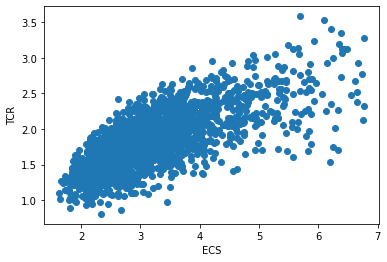

In [5]:
# draw distributions of ECS and TCR: 5-95% range 1.0 to 2.2 for TCR normal, 2-5 for ECS lognormal
seed    = SEEDS[9]

feedback = 4/3 * st.truncnorm.rvs(-2.0, np.inf, loc=1, scale=0.28, size=SAMPLES, random_state=SEEDS[18])
f2x = 4.00
ecs = f2x/feedback
rwf = st.norm.rvs(size=SAMPLES, loc=np.maximum(0.8*np.exp(-0.075*ecs**1.2), 0.2), scale=0.11*np.exp(-0.09*ecs**0.9), random_state=11)
tcr = ecs*rwf
tcrecs = np.stack((tcr,ecs)).T

pl.scatter(ecs, tcr)
pl.xlabel('ECS')
pl.ylabel('TCR')
print(np.corrcoef((ecs,tcr))[0,1])
print(np.percentile(ecs, (5,16,50,84,95)))
print(np.percentile(tcr, (5,17,50,83,95)))

kappa = f2x/tcr - f2x/ecs

f2x = st.norm.rvs(loc=F2XCO2_MEAN, scale=F2XCO2_NINETY/NINETY_TO_ONESIGMA, size=SAMPLES, random_state=SEEDS[72])

with open("../data_output/cmip6_twolayer_tuning_params.json", "r") as read_file:
    cmip6_models = json.load(read_file)
params = pd.DataFrame({
    param:cmip6_models[param]['model_data'] for param in cmip6_models
})
params.drop(columns=['T4xCO2'], inplace=True)
NMODELS = len(cmip6_models)

lambda0 = feedback
efficacy = st.norm.rvs(loc=params.efficacy.mean(), scale=params.efficacy.std(), size=SAMPLES, random_state=SEEDS[65])
eta = kappa/efficacy
dl = st.truncnorm.rvs(-NINETY_TO_ONESIGMA, NINETY_TO_ONESIGMA, loc=params.dl.mean(), scale=params.dl.std(), size=SAMPLES, random_state=SEEDS[66])
du = st.truncnorm.rvs(-NINETY_TO_ONESIGMA, NINETY_TO_ONESIGMA, loc=params.du.mean(), scale=params.du.std(), size=SAMPLES, random_state=SEEDS[67])

## Forcing uncertainties

In [6]:
seed    = 36572 
NINETY_TO_ONESIGMA = st.norm.ppf(0.95)

# to do move to module

# these are standard deviations of the scale factor for normally distributed forcings (mean = 1). The list below is expressed in terms of 5-95% ranges.
unc_ranges = np.array([
    0.12,      # CO2
    0.20,      # CH4: updated value from etminan 2016
    0.14,      # N2O
    0.19,      # other WMGHGs
    0.50,      # Total ozone
    1.00,      # stratospheric WV from CH4
    0.70,      # contrails approx - half-normal
    1.25,      # bc on snow - half-normal
    0.50,      # land use change
    5.0/20.0,  # volcanic
    0.50,      # solar (amplitude)
])/NINETY_TO_ONESIGMA

scale = st.norm.rvs(size=(SAMPLES,11), loc=np.ones((SAMPLES,11)), scale=np.ones((SAMPLES, 11)) * unc_ranges[None,:], random_state=seed)
#scale[:,8] = st.lognorm.rvs(0.5, size=samples, random_state=seed+1)
# refine this calc and maybe half normal it

# here's a half normal
## bc snow is asymmetric Gaussian. We can just scale the half of the distribution above/below best estimate
scale[scale[:,7]<1,7] = 0.06/0.1*(scale[scale[:,7]<1,7]-1) + 1

## so is contrails - the benefits of doing this are tiny :)
scale[scale[:,6]<1,6] = 0.0384/0.0406*(scale[scale[:,6]<1,6]-1) + 1

trend_solar = st.norm.rvs(size=SAMPLES, loc=+0.01, scale=0.07/NINETY_TO_ONESIGMA, random_state=138294)
#trend_solar[trend_solar>-0.01] = 11/4 * (trend_solar[trend_solar>-0.01]+0.01)-0.01

scale_df = pd.DataFrame(
    data = scale,
    columns = ['co2','ch4','n2o','other_wmghg','o3','h2o_stratospheric','contrails','bc_on_snow','land_use','volcanic','solar']
)

### Aerosol emissions

For ERFaci, following Smith, Harris et al. 2020: Energy Budget Constraints on the Time History of Aerosol Forcing and Climate Sensitivity

For ERFari, start with Smith, Harris et al. and then add in the nitrate forcing from Myhre et al 2013

For ERFari, take coefficients from Myhre et al., 2013: Radiative forcing of the direct aerosol effect from AeroCom Phase II
simulations. The forcing calculated is 1850-2000 (or 2006; assume the same) using CMIP5 emissions.

In [7]:
df = pd.read_csv('../data_input_large/ERFaci_samples.csv')
aci_coeffs = np.exp(df.values)

NINETY_TO_ONESIGMA = st.norm.ppf(0.95)

# SCALE TO ASSESSMENT
ERFari_scale = st.norm.rvs(loc=-0.30, scale=0.30/NINETY_TO_ONESIGMA, size=SAMPLES, random_state=786418)
ERFaci_scale = st.norm.rvs(loc=-1.00, scale=0.65/NINETY_TO_ONESIGMA, size=SAMPLES, random_state=31318990)

ERFari = np.zeros((270,SAMPLES))
ERFaci = np.zeros((270,SAMPLES))
    
bc = emissions_ceds_update['BC'].values.squeeze()
oc = emissions_ceds_update['OC'].values.squeeze()
so2 = emissions_ceds_update['SO2'].values.squeeze()
nh3 = emissions_ceds_update['NH3'].values.squeeze()

for i in tqdm(range(SAMPLES)):
    ts2010 = np.mean(
        ghan(
            [
                so2[255:265],
                    bc[255:265]+
                    oc[255:265],
            ], 1.11, aci_coeffs[i,0], aci_coeffs[i,1]
        )
    )
    ts1750 = ghan(
        [
            so2[0],
                bc[0]+
                oc[0],
        ], 1.11, aci_coeffs[i,0], aci_coeffs[i,1]
    )
    ERFaci[:,i] = (
        ghan([so2, bc+oc], 1.11, aci_coeffs[i,0], aci_coeffs[i,1])
    - ts1750)/(ts2010-ts1750)*ERFaci_scale[i]

In [8]:
bc_20101750 = st.norm.rvs(loc=0.3, scale=0.2/NINETY_TO_ONESIGMA, size=SAMPLES, random_state=SEEDS[95])
oc_20101750 = st.norm.rvs(loc=-0.09, scale=0.07/NINETY_TO_ONESIGMA, size=SAMPLES, random_state=SEEDS[96])
so2_20101750 = st.norm.rvs(loc=-0.4, scale=0.2/NINETY_TO_ONESIGMA, size=SAMPLES, random_state=SEEDS[97])
nh3_20101750 = st.norm.rvs(loc=-0.11, scale=0.05/NINETY_TO_ONESIGMA, size=SAMPLES, random_state=SEEDS[98])

beta_bc = bc_20101750/(np.mean(emissions_ceds_update.loc[2005:2014,'BC'])-emissions_ceds_update.loc[1750,'BC'])
beta_oc = oc_20101750/(np.mean(emissions_ceds_update.loc[2005:2014,'OC'])-emissions_ceds_update.loc[1750,'OC'])
beta_so2 = so2_20101750/(np.mean(emissions_ceds_update.loc[2005:2014,'SO2'])-emissions_ceds_update.loc[1750,'SO2'])
beta_nh3 = nh3_20101750/(np.mean(emissions_ceds_update.loc[2005:2014,'NH3'])-emissions_ceds_update.loc[1750,'NH3'])

ERFari = np.zeros((270, SAMPLES))
for i in tqdm(range(SAMPLES)):
    ERFari[:, i] = (
        (emissions_ceds_update.loc[:,'SO2']-emissions_ceds_update.loc[1750,'SO2']) * beta_so2[i] +
        (emissions_ceds_update.loc[:,'BC']-emissions_ceds_update.loc[1750,'BC']) * beta_bc[i] +
        (emissions_ceds_update.loc[:,'OC']-emissions_ceds_update.loc[1750,'OC']) * beta_oc[i] +
        (emissions_ceds_update.loc[:,'NH3']-emissions_ceds_update.loc[1750,'NH3']) * beta_nh3[i]
    )
    
beta_bc = 0.3/(np.mean(emissions_ceds_update.loc[2005:2014,'BC'])-emissions_ceds_update.loc[1750,'BC'])
beta_oc = -0.09/(np.mean(emissions_ceds_update.loc[2005:2014,'OC'])-emissions_ceds_update.loc[1750,'OC'])
beta_so2 = -0.4/(np.mean(emissions_ceds_update.loc[2005:2014,'SO2'])-emissions_ceds_update.loc[1750,'SO2'])
beta_nh3 = -0.11/(np.mean(emissions_ceds_update.loc[2005:2014,'NH3'])-emissions_ceds_update.loc[1750,'NH3'])

ERFari_median = (
        (emissions_ceds_update.loc[:,'SO2']-emissions_ceds_update.loc[1750,'SO2']) * beta_so2 +
        (emissions_ceds_update.loc[:,'BC']-emissions_ceds_update.loc[1750,'BC']) * beta_bc +
        (emissions_ceds_update.loc[:,'OC']-emissions_ceds_update.loc[1750,'OC']) * beta_oc +
        (emissions_ceds_update.loc[:,'NH3']-emissions_ceds_update.loc[1750,'NH3']) * beta_nh3 
    )
ERFaci_median = np.percentile(ERFaci, 50, axis=1) * (-1.0)/(np.percentile(ERFaci, 50, axis=1)[255:265].mean())

## Non-aerosol forcings

In [9]:
df = pd.read_csv('../data_output/AR6_ERF_1750-2019.csv')
forcing_ensemble = {}
forcing_ensemble['co2'] = df['co2'].values[:,None] * scale_df['co2'].values[None,:]
forcing_ensemble['ch4'] = df['ch4'].values[:,None] * scale_df['ch4'].values[None,:]
forcing_ensemble['n2o'] = df['n2o'].values[:,None] * scale_df['n2o'].values[None,:]
forcing_ensemble['other_wmghg'] = df['other_wmghg'].values[:,None] * scale_df['other_wmghg'].values[None,:]
forcing_ensemble['o3'] = df['o3'].values[:,None] * scale_df['o3'].values[None,:]
forcing_ensemble['h2o_stratospheric'] = df['h2o_stratospheric'].values[:,None] * scale_df['h2o_stratospheric'].values[None,:]
forcing_ensemble['contrails'] = df['contrails'].values[:,None] * scale_df['contrails'].values[None,:]
forcing_ensemble['aerosol-radiation_interactions'] = ERFari
forcing_ensemble['aerosol-cloud_interactions'] = ERFaci
forcing_ensemble['bc_on_snow'] = df['bc_on_snow'].values[:,None] * scale_df['bc_on_snow'].values[None,:]
forcing_ensemble['land_use'] = df['land_use'].values[:,None] * scale_df['land_use'].values[None,:]
forcing_ensemble['volcanic'] = df['volcanic'].values[:,None] * scale_df['volcanic'].values[None,:]
forcing_ensemble['solar'] = df['solar'].values[:,None] * scale_df['solar'].values[None,:]
forcing_ensemble['total'] = (
    forcing_ensemble['co2'] +
    forcing_ensemble['ch4'] +
    forcing_ensemble['n2o'] +
    forcing_ensemble['other_wmghg'] +
    forcing_ensemble['o3'] +
    forcing_ensemble['h2o_stratospheric'] +
    forcing_ensemble['contrails'] +
    forcing_ensemble['aerosol-radiation_interactions'] +
    forcing_ensemble['aerosol-cloud_interactions'] +
    forcing_ensemble['bc_on_snow'] +
    forcing_ensemble['land_use'] +
    forcing_ensemble['volcanic'] +
    forcing_ensemble['solar']
)

In [10]:
forcing_ensemble['total'][:,0].shape

(270,)

In [11]:
list(forcing_ensemble.keys())[:-1]

['co2',
 'ch4',
 'n2o',
 'other_wmghg',
 'o3',
 'h2o_stratospheric',
 'contrails',
 'aerosol-radiation_interactions',
 'aerosol-cloud_interactions',
 'bc_on_snow',
 'land_use',
 'volcanic',
 'solar']

# Run climate model

Remove one forcing at a time, and take differences WRT the all forcing.

Use ECS = 3, TCR = 1.8, central CMIP6 values for dl, du, eta, efficacy

In [12]:
ecs = 3.0
tcr = 1.8
f2x = 4.0
lambda0 = f2x / ecs
kappa = f2x/tcr - f2x/ecs
print(kappa)
print((params.efficacy * params.eta).mean())
# let's go with efficacy as given and scale eta accordingly
eta = kappa/params.efficacy.mean()
eta

0.8888888888888891
0.8262461955369731


0.6862967868401252

## Only varying the forcing

In [13]:
arglist = []

for i in range(SAMPLES):
    arglist.append(
        {
            'in_forcing' : forcing_ensemble['total'][:,i],
            'run_id': i
        }
    )

In [14]:
runner = TwoLayerModel()
output = []

results = {}
results['AR6-historical'] = {}

dl = params.dl.mean()# * ur(cmip6_models['dl']['units'])
du = params.du.mean()#  * ur(cmip6_models['du']['units'])
eta = eta# * ur(cmip6_models['eta']['units'])
lambda0 = lambda0# *  ur(cmip6_models['lambda0']['units'])
efficacy = params.efficacy.mean()# * ur(cmip6_models['efficacy']['units'])

def run_tlm(args):
    in_forcing = args['in_forcing']
    driver = ScmRun(
        data=in_forcing,#[:,None]*np.ones((270,500)),
        index=np.arange(1750,2020),
        columns={
            "unit": "W/m^2",
            "model": "openscm-twolayermodel-0.2.0",
            "scenario": "historical-AR6",
            "region": "World",
            "variable": "Effective Radiative Forcing",
            "run_id": args['run_id']
        }
    )
    runner.dl = dl*ur(cmip6_models['dl']['units'])
    runner.du = du*ur(cmip6_models['du']['units'])
    runner.eta = eta*ur(cmip6_models['eta']['units'])
    runner.lambda0 = lambda0 * ur(cmip6_models['lambda0']['units'])
    runner.efficacy = efficacy * ur(cmip6_models['efficacy']['units'])
    return (runner.run_scenarios(driver, progress=False))
    
    
if __name__ == '__main__':
    with Pool(16) as pool:
        result = list(tqdm(pool.imap(run_tlm, arglist), total=SAMPLES))
    output = run_append(result)

MODEL_TIMESTEP = runner.delta_t.to('s').magnitude
results['AR6-historical']['effective_radiative_forcing'] = output.filter(variable='Effective Radiative Forcing').timeseries().values.T
results['AR6-historical']['surface_temperature'] = output.filter(variable='Surface Temperature|Upper').timeseries().values.T


if __name__ == '__main__':
    for agent in tqdm(list(forcing_ensemble.keys())[:-1], desc='Removing one at a time'):
        arglist = []
        for i in range(SAMPLES):
            in_forcing = forcing_ensemble['total'][:,i] - forcing_ensemble[agent][:,i]
            arglist.append(
                {
                    'in_forcing' : in_forcing,
                    'run_id': i
                }
            )
        output = []
        results['remove_%s' % agent] = {}
        with Pool(16) as pool:
            result = list(tqdm(pool.imap(run_tlm, arglist), total=SAMPLES, leave=False))
        output = run_append(result)

        results['remove_%s' % agent]['effective_radiative_forcing'] = output.filter(variable='Effective Radiative Forcing').timeseries().values.T
        results['remove_%s' % agent]['surface_temperature'] = output.filter(variable='Surface Temperature|Upper').timeseries().values.T

In [15]:
#save_dict_to_hdf5(results, '../data_input_large/ERF_leave_one_out.h5')

Text(0.5, 1.0, 'temperature impact of ERFaci')

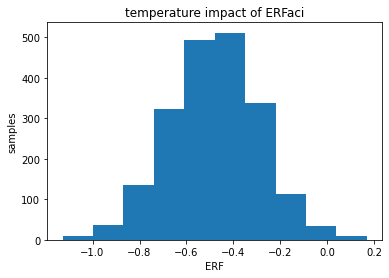

In [16]:
pl.hist((results['AR6-historical']['surface_temperature']-results['remove_aerosol-cloud_interactions']['surface_temperature'])[-1,:])
pl.xlabel('ERF')
pl.ylabel('samples')
pl.title('temperature impact of ERFaci')

In [17]:
np.mean((results['AR6-historical']['surface_temperature']-results['remove_aerosol-cloud_interactions']['surface_temperature'])[-1,:])

-0.4823339195975105

In [18]:
np.mean((results['AR6-historical']['surface_temperature']-results['remove_aerosol-radiation_interactions']['surface_temperature'])[-1,:])

-0.1253383904692148

## Varying the forcing, climate sensitivity and two-layer model response

In [19]:
f2x = st.norm.rvs(loc=F2XCO2_MEAN, scale=F2XCO2_NINETY/NINETY_TO_ONESIGMA, size=SAMPLES, random_state=SEEDS[72])

with open("../data_output/cmip6_twolayer_tuning_params.json", "r") as read_file:
    cmip6_models = json.load(read_file)
params = pd.DataFrame({
    param:cmip6_models[param]['model_data'] for param in cmip6_models
})
params.drop(columns=['T4xCO2'], inplace=True)
NMODELS = len(cmip6_models)

lambda0 = feedback
efficacy = st.norm.rvs(loc=params.efficacy.mean(), scale=params.efficacy.std(), size=SAMPLES, random_state=SEEDS[65])
eta = kappa/efficacy
dl = st.truncnorm.rvs(-NINETY_TO_ONESIGMA, NINETY_TO_ONESIGMA, loc=params.dl.mean(), scale=params.dl.std(), size=SAMPLES, random_state=SEEDS[66])
du = st.truncnorm.rvs(-NINETY_TO_ONESIGMA, NINETY_TO_ONESIGMA, loc=params.du.mean(), scale=params.du.std(), size=SAMPLES, random_state=SEEDS[67])

In [20]:
arglist = []

dl = np.array(dl)
du = np.array(du)
eta = np.array(eta)
lambda0 = np.array(lambda0)
efficacy = np.array(efficacy)

for i in range(SAMPLES):
    arglist.append(
        {
            'dl': dl[i],
            'du': du[i],
            'eta': eta[i],
            'lambda0': lambda0[i],
            'efficacy': efficacy[i],
            'in_forcing' : forcing_ensemble['total'][:,i],
            'run_id': i
        }
    )

In [21]:
runner = TwoLayerModel()
output = []

results['AR6-historical_climuncert'] = {}

def run_tlm(args):
    in_forcing = args['in_forcing']
    driver = ScmRun(
        data=in_forcing,#[:,None]*np.ones((270,500)),
        index=np.arange(1750,2020),
        columns={
            "unit": "W/m^2",
            "model": "openscm-twolayermodel-0.2.0",
            "scenario": "historical-AR6",
            "region": "World",
            "variable": "Effective Radiative Forcing",
            "run_id": args['run_id']
        }
    )
    runner.dl = args['dl']*ur(cmip6_models['dl']['units'])
    runner.du = args['du']*ur(cmip6_models['du']['units'])
    runner.eta = args['eta']*ur(cmip6_models['eta']['units'])
    runner.lambda0 = args['lambda0'] * ur(cmip6_models['lambda0']['units'])
    runner.efficacy = args['efficacy'] * ur(cmip6_models['efficacy']['units'])
    return (runner.run_scenarios(driver, progress=False))
    
    
if __name__ == '__main__':
    with Pool(16) as pool:
        result = list(tqdm(pool.imap(run_tlm, arglist), total=SAMPLES))
    output = run_append(result)

MODEL_TIMESTEP = runner.delta_t.to('s').magnitude
results['AR6-historical_climuncert']['effective_radiative_forcing'] = output.filter(variable='Effective Radiative Forcing').timeseries().values.T
results['AR6-historical_climuncert']['surface_temperature'] = output.filter(variable='Surface Temperature|Upper').timeseries().values.T


if __name__ == '__main__':
    for agent in tqdm(list(forcing_ensemble.keys())[:-1], desc='Removing one at a time'):
        arglist = []
        for i in range(SAMPLES):
            in_forcing = forcing_ensemble['total'][:,i] - forcing_ensemble[agent][:,i]
            arglist.append(
                {
                    'in_forcing' : in_forcing,
                    'run_id': i,
                    'dl': dl[i],
                    'du': du[i],
                    'eta': eta[i],
                    'lambda0': lambda0[i],
                    'efficacy': efficacy[i],
                }
            )
        output = []
        results['remove_%s_climuncert' % agent] = {}
        with Pool(16) as pool:
            result = list(tqdm(pool.imap(run_tlm, arglist), total=SAMPLES, leave=False))
        output = run_append(result)

        results['remove_%s_climuncert' % agent]['effective_radiative_forcing'] = output.filter(variable='Effective Radiative Forcing').timeseries().values.T
        results['remove_%s_climuncert' % agent]['surface_temperature'] = output.filter(variable='Surface Temperature|Upper').timeseries().values.T

In [22]:
save_dict_to_hdf5(results, '../data_input_large/ERF_leave_one_out.h5')